# Polyphase Filter-Bank Inversion Spectral Fidelity Notebook

This notebook demonstrates using the `PyDADA` library to analyse files that have been produced by `DSPSR` that includes
polyphase filter-bank (PFB) inverted data.

The `PyDADA` library currently only supports 1 output channel (`NCHAN=1`) and 1 polarisation (`NPOL=1`)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np

from ska_pydada.utils import SpectralFidelityResult, analyse_pfb_spectral_fidelity

In [3]:
# setup logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

## Example of processing valid PFB data

The following cells demonstrate using the `analyse_pfb_spectral_fidelity` from `PyDADA` to get
a result dataclass instance (`SpectralFidelityResult`) and how to use that dataclass.

The output file from `DSPSR` provides complex floating point data in time, frequency and polarisation order (TFP). This particular file had the number of inverse fast Fourier transform (IFFT) bins as `165888`.

For SKA Low the requirements are as follows:

### Maximum Spectral Confusion 

* the maximum allowable power relative to the power in the expected frequency bin, ***Xmax*** = -60 dB

### Total Spectral Confusion

* the maximum allowable total spurious power integrated over all frequency bins (other than the expected frequency bin) relative to the power in the expected frequency bin, ***Smax*** = -50 dB

### Python API to analyse file

The Python method `analyse_pfb_spectral_fidelity` takes the following:

```
analyse_pfb_spectral_fidelity(
    file="data/inverted_spectral_pass.dada",
    t_test=TTEST,
    t_ifft=TIFFT,
    expected_tones=expected,
    max_power_db=-60.0,
    max_total_spectral_confusion_power_db=-50.0,
)
```

* a file path (relative or absolute and can be a `pathlib.Path` object too)
* $T_{test}$ using the `t_test` argument
* $T_{ifft}$ using the `t_ifft` argument
* a list of indices of where a frequency tone is expected (the `expected_tones` argument)
* the ***Xmax*** using the `max_power_db` argument, default is `-60.0`
* the ***Smax*** using the `max_total_spectral_confusion_power_db` argument, the default is `-50.0`



In [4]:
T_IFFT = 165888
T_TEST = 290304

SKA_LOW_X_MAX = -60.0
SKA_LOW_S_MAX = -50.0

### Perfom analysis on a file that should pass

#### Use the PyDADA analyse_pfb_spectral_fidelity function to do analysis

The following cells show how to use `analyse_pfb_spectral_fidelity` to do the analysis and to easily check if the file passes the SKA PFB inversion requirements

In [5]:
expected_tones = [82944, 165240, 82296]

expected_to_pass: SpectralFidelityResult = analyse_pfb_spectral_fidelity(
    "data/inverted_spectral_pass.dada",
    t_test=T_TEST,
    t_ifft=T_IFFT,
    max_power_db=SKA_LOW_X_MAX,
    max_total_spectral_confusion_power_db=SKA_LOW_S_MAX,
    expected_tones=expected_tones,
)

The output of the result can be printed as follows.

In the case of this file one can see that the `overall_result` is `True` (i.e. valid) and for each tone there is a result which both have the following:

* the tone and the expected tone are at the same frequency bin index
* the `max_spectral_confusion_result` is `True` (i.e. valid)
* the `total_spectral_confusion_power_result` is `True` (i.e. valid)

In [6]:
pprint.pprint(expected_to_pass)

SpectralFidelityResult(tsamp=1.28,
                       overall_result=False,
                       tone_results=[SpectralFidelityToneResult(time_sample_start_idx=0,
                                                                frequency_bin_idx=82944,
                                                                expected_frequency_bin_idx=82944,
                                                                valid_frequency_bin=True,
                                                                max_spectral_confusion_result=False,
                                                                total_spectral_confusion_power_result=False,
                                                                total_spectral_confusion_power_db=-8.150981664657593,
                                                                overall_result=False),
                                     SpectralFidelityToneResult(time_sample_start_idx=290304,
                                             

Perform the assertions to ensure that we have the correct tone index and assert spectral confusion requirements

***NOTE***: currently the SKA PFB inversion does not meet the spectral confusion requirements and is still under investigation.

In [7]:
# assert expected_to_pass.overall_result, "expected file to pass spectral fidelity analysis"

for expected_frequency_bin_idx, r in zip(expected_tones, expected_to_pass.tone_results):
    assert r.expected_frequency_bin_idx == expected_frequency_bin_idx
    assert r.frequency_bin_idx == expected_frequency_bin_idx
    assert r.valid_frequency_bin
    # Currently failing
    # assert r.max_spectral_confusion_result
    # assert len(r.max_spectral_confusion_result_idx) == 0
    # assert r.total_spectral_confusion_power_result
    # assert r.total_spectral_confusion_power_db <= SKA_LOW_S_MAX

Plot the frequency channels and a zoomed in version with $\pm 20$ channels of expected frequency bin

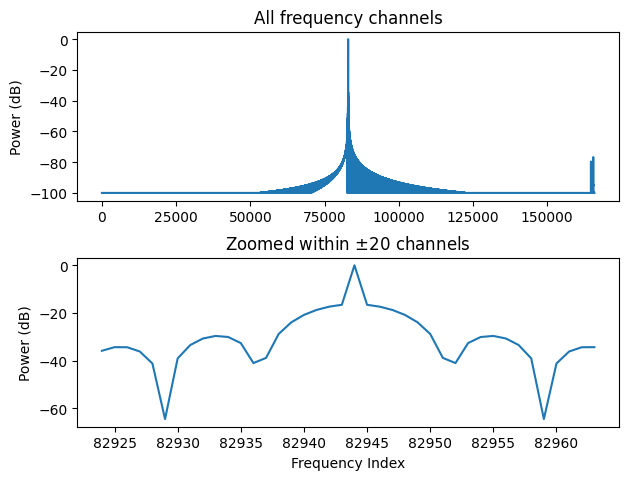

In [8]:
fig, axs = plt.subplots(2)
fig.tight_layout(pad=2.0)

index = expected_to_pass.tone_results[0].expected_frequency_bin_idx
dB = expected_to_pass.tone_results[0].signal_power_db
xval = np.arange(0, T_IFFT)

axs[0].plot(xval, dB)
axs[0].set(ylabel="Power (dB)")
axs[0].set_title("All frequency channels")

xbuf = 20
xmin = index - xbuf
xmax = index + xbuf

zoom_dB = dB[xmin:xmax]
zoom_xval = xval[xmin:xmax]

axs[1].plot(zoom_xval, zoom_dB)
axs[1].set(ylabel="Power (dB)", xlabel="Frequency Index")
axs[1].set_title(r"Zoomed within $\pm 20$ channels")

plt.show()

### Perform analysis on a file that should fail

#### Use the PyDADA analyse_pfb_spectral_fidelity function to do analysis

The following cells show how to use `analyse_pfb_spectral_fidelity` to do the analysis and to easily check if the file passes the SKA PFB inversion requirements

In [9]:
expected_to_fail = analyse_pfb_spectral_fidelity(
    "data/inverted_spectral_fail.dada",
    t_test=T_TEST,
    t_ifft=T_IFFT,
    max_power_db=SKA_LOW_X_MAX,
    max_total_spectral_confusion_power_db=SKA_LOW_S_MAX,
    expected_tones=expected_tones,
)

In [10]:
pprint.pprint(expected_to_fail)

SpectralFidelityResult(tsamp=1.28,
                       overall_result=False,
                       tone_results=[SpectralFidelityToneResult(time_sample_start_idx=0,
                                                                frequency_bin_idx=82944,
                                                                expected_frequency_bin_idx=82944,
                                                                valid_frequency_bin=True,
                                                                max_spectral_confusion_result=False,
                                                                total_spectral_confusion_power_result=False,
                                                                total_spectral_confusion_power_db=-8.11428189277649,
                                                                overall_result=False),
                                     SpectralFidelityToneResult(time_sample_start_idx=290304,
                                              

Perform the assertions to ensure that we have the correct tone index and assert spectral confusion requirements

In this case we will need to assert that max spectral confusion and total spectral confusion fail as the file itself was set up to fail

In [11]:
assert not expected_to_fail.overall_result, "expected file to fail spectral fidelity analysis"

for expected_frequency_bin_idx, r in zip(expected_tones, expected_to_fail.tone_results):
    assert r.expected_frequency_bin_idx == expected_frequency_bin_idx
    assert r.frequency_bin_idx == expected_frequency_bin_idx
    assert r.valid_frequency_bin
    assert not r.max_spectral_confusion_result
    assert len(r.max_spectral_confusion_result_idx) > 0
    assert not r.total_spectral_confusion_power_result
    assert r.total_spectral_confusion_power_db > SKA_LOW_S_MAX

One can check to see what indices have power outside of the allowed spectral confusion

In [12]:
failed_max_spectral_confusion_indicies = expected_to_fail.tone_results[0].max_spectral_confusion_result_idx
len(failed_max_spectral_confusion_indicies)

465

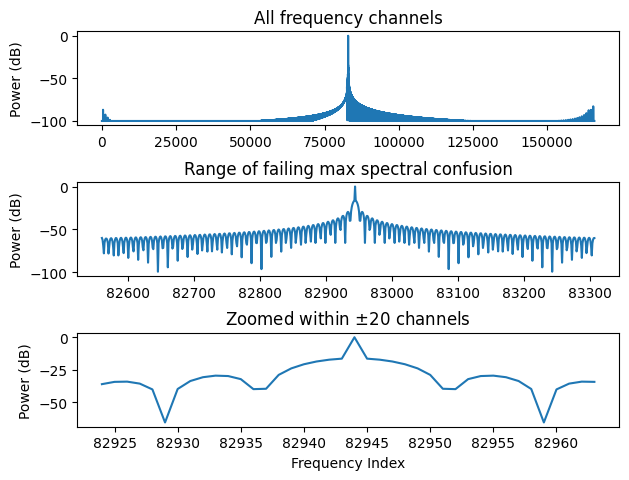

In [13]:
fig, axs = plt.subplots(3)
fig.tight_layout(pad=2.0)

index = expected_to_fail.tone_results[0].expected_frequency_bin_idx
dB = expected_to_fail.tone_results[0].signal_power_db

# All channels
axs[0].plot(xval, dB)
axs[0].set(ylabel="Power (dB)")
axs[0].set_title("All frequency channels")

# Range over failing max spectral confusion
idx_range = np.arange(
    failed_max_spectral_confusion_indicies[0], failed_max_spectral_confusion_indicies[-1] + 1
)

axs[1].plot(xval[idx_range], dB[idx_range])
axs[1].set(ylabel="Power (dB)")
axs[1].set_title("Range of failing max spectral confusion")

# Zoom
xbuf = 20
xmin = index - xbuf
xmax = index + xbuf

zoom_dB = dB[xmin:xmax]
zoom_xval = xval[xmin:xmax]

axs[2].plot(zoom_xval, zoom_dB)
axs[2].set(ylabel="Power (dB)", xlabel="Frequency Index")
axs[2].set_title(r"Zoomed within $\pm 20$ channels")

plt.show()